### Install Python SDKs

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install sagemaker-experiments

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (20.0.2)


### Setup

In [3]:
import time

import boto3
import numpy as np
from PIL import Image
import pandas as pd
import torch, torchvision
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [4]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = get_execution_role()

### Create a S3 bucket to hold data

In [5]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
bucket = 'sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print(e)

An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [6]:
bucket='sagemaker-us-east-2-322537213286'

### Dataset
We download the dataset, and then apply transformation on each of the image.

In [7]:
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    transforms.RandomAffine(0, translate=None, scale=None, shear=None, resample=False, fillcolor=0),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_dataset = datasets.ImageFolder(root='./Skincare-cnn/dataset_images/training_set/', # 샘플 dataset 위치
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = datasets.ImageFolder(root='./Skincare-cnn/dataset_images/test_set//', # 샘플 dataset 위치
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)

  lentigo simplex angioma basal cell carcinoma pigmented benign keratosis vascular lesion nevus lichenoid keratosis   nan actinic keratosis dermatofibroma


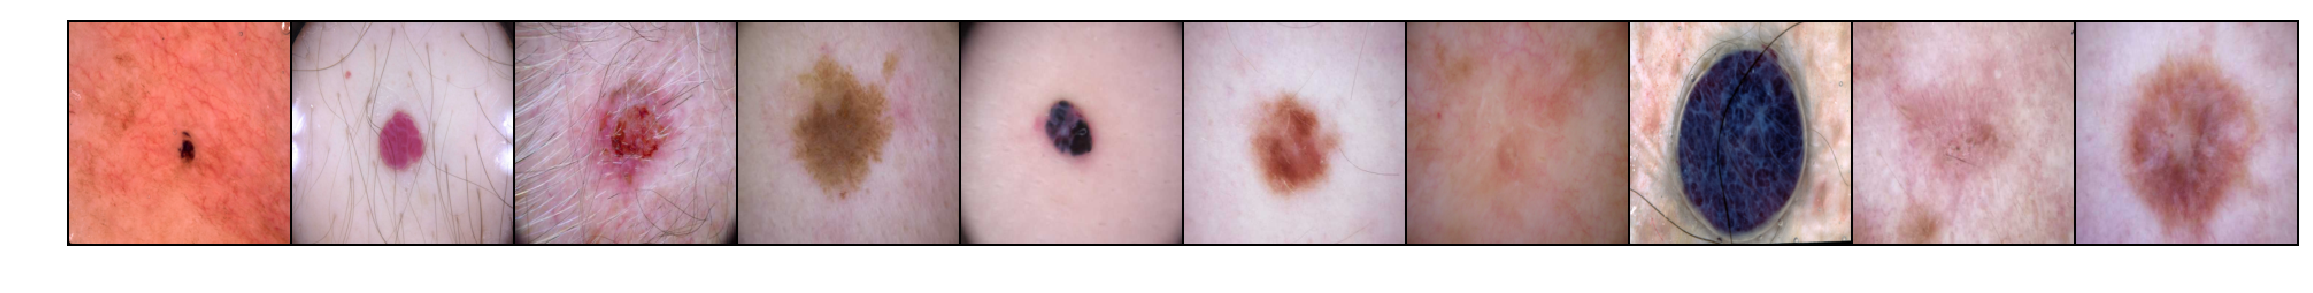

In [8]:
import glob
from random import sample

path = './Skincare-cnn/dataset_images/test_set/'
row_cnt = len(test_dataset.classes)
image_list = []
label_list = []

for class_name in glob.glob(path + '*'):
    file_name = sample(glob.glob(class_name+'/*'),1)[0]
    img_arr = np.array(Image.open(file_name))
    img = Image.fromarray(img_arr.astype('uint8')).convert('RGB')
    img = transforms.Resize((192, 192))(img)
    img = transforms.ToTensor()(img)
    image_list.append(img)
    label_list.append(file_name.split('/')[4])
    
def imshow_result(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 10))
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# # show images
# imshow_result(torchvision.utils.make_grid(image_list[1::2], nrow=row_cnt))

# print labels
print(' ', ' '.join('%5s' % labels for labels in label_list[0::2]))
imshow_result(torchvision.utils.make_grid(image_list[0::2], nrow=row_cnt))

  other atypical melanocytic proliferation  scar squamous cell carcinoma seborrheic keratosis angiofibroma or fibrous papule solar lentigo lentigo NOS melanoma


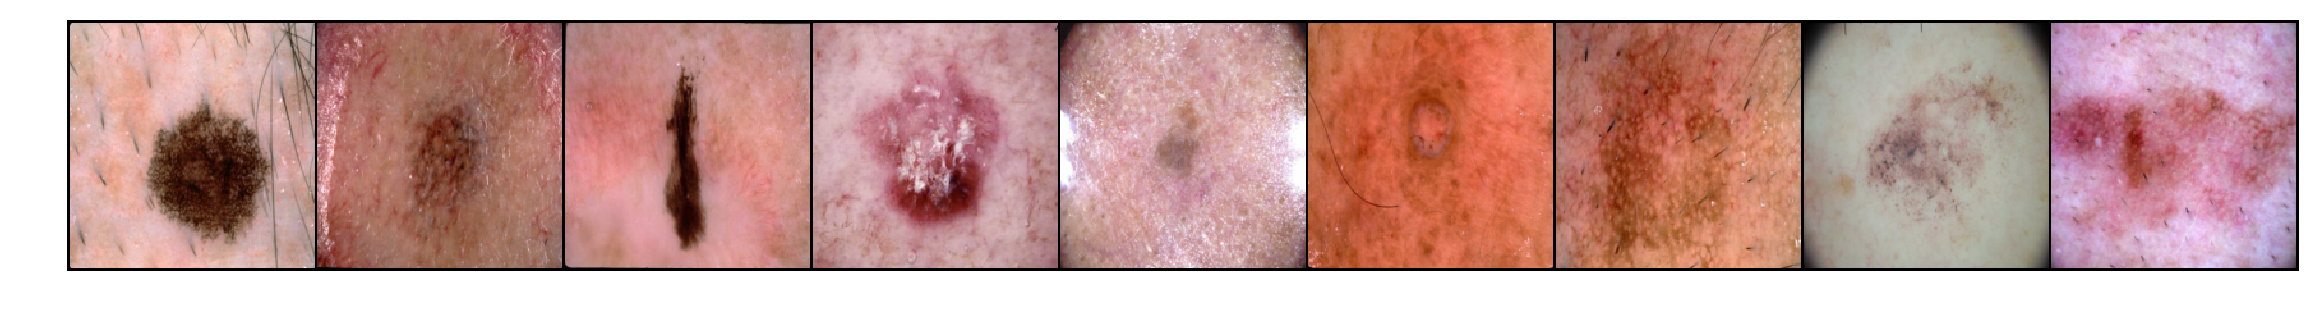

In [9]:
print(' ', ' '.join('%5s' % labels for labels in label_list[1::2]))
imshow_result(torchvision.utils.make_grid(image_list[1::2], nrow=row_cnt))

After transforming the images in the dataset, we upload it to s3.

In [10]:
# prefix = 'skincare'
# inputs = sagemaker.Session().upload_data(path='./Skincare-cnn/dataset_images/', bucket=bucket, key_prefix=prefix)
# print('input spec: {}'.format(inputs))

Now lets track the parameters from the data pre-processing step.

In [11]:
inputs = 's3://sagemaker-us-east-2-322537213286/skincare'

In [12]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "normalization_mean": 0.5,
        "normalization_std": 0.5,
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="skincare-dataset", media_type="s3/uri", value=inputs)

### Step 1 - Set up the Experiment

Create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work for : [1] a business use case you are addressing (e.g. create experiment named “customer churn prediction”), or [2] a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”), or [3] a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

### Create an Experiment

In [13]:
skincare_experiment = Experiment.create(
    experiment_name=f"skincare-classification-{int(time.time())}", 
    description="Classification of skincare images", 
    sagemaker_boto_client=sm)
print(skincare_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f66ea54e5f8>,experiment_name='skincare-classification-1587828746',description='Classification of skincare images',experiment_arn='arn:aws:sagemaker:us-east-2:322537213286:experiment/skincare-classification-1587828746',response_metadata={'RequestId': 'ab8b69e1-76fd-48b6-9b0d-ab382511aef0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'ab8b69e1-76fd-48b6-9b0d-ab382511aef0', 'content-type': 'application/x-amz-json-1.1', 'content-length': '106', 'date': 'Sat, 25 Apr 2020 15:32:26 GMT'}, 'RetryAttempts': 0})


### Step 2 - Track Experiment
### Now create a Trial for each training run to track the it's inputs, parameters, and metrics.
While training the CNN model on SageMaker, we will experiment with several values for the number of hidden channel in the model. We will create a Trial to track each training job run. We will also create a TrialComponent from the tracker we created before, and add to the Trial. This will enrich the Trial with the parameters we captured from the data pre-processing stage.

Note the execution of the following code takes a while.

In [14]:
from sagemaker.pytorch import PyTorch, PyTorchModel

In [15]:
hidden_channel_trial_name_map = {}

If you want to run the following training jobs asynchronously, you may need to increase your resource limit. Otherwise, you can run them sequentially.

In [16]:
preprocessing_trial_component = tracker.trial_component

In [17]:
hyperparameters = {
        'epochs': 3,
        'batch-size' : 16,
        'backend': 'nccl',
        'kernel_size': 5,
        'optimizer': 'adam',
        'lr': 0.001,
#         'horovod': True,
#         'apex' : True,
#         'opt-level' : 'O1'
    }

In [18]:
image_name = '322537213286.dkr.ecr.us-east-2.amazonaws.com/pytorch-training-apex:1.4.0-gpu-py3'

In [ ]:
%%time
# create trial
trial_name = f"cnn-training-job-{int(time.time())}"
cnn_trial = Trial.create(
    trial_name=trial_name, 
    experiment_name=skincare_experiment.experiment_name,
    sagemaker_boto_client=sm,
)
# hidden_channel_trial_name_map[num_hidden_channel] = trial_name

# associate the proprocessing trial component with the current trial
cnn_trial.add_trial_component(preprocessing_trial_component)

# all input configurations, parameters, and metrics specified in estimator 
# definition are automatically tracked
estimator = PyTorch(
    entry_point='./main_trainer.py',
    source_dir='./mgmd',
    role=role,
    sagemaker_session=sagemaker.Session(sagemaker_client=sm),
    framework_version='1.4.0',
    image_name=image_name,
    train_instance_count=1,
    train_instance_type='ml.p3.2xlarge',
#     train_use_spot_instances=True,  # spot instance 활용
#     train_volume_size=400,
#     train_max_run=12*60*60,
#     train_max_wait=12*60*60,
    hyperparameters=hyperparameters,
#     checkpoint_s3_uri=checkpoint_s3_uri,
#     tensorboard_output_config=TensorBoardOutputConfig(tensorboard_output),
    metric_definitions=[
        {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
        {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
        {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
    ],
    enable_sagemaker_metrics=True
)

cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))

# Now associate the estimator with the Experiment and Trial
estimator.fit(
    inputs={'training': inputs}, 
    job_name=cnn_training_job_name,
    logs='All',
    experiment_config={
        "TrialName": cnn_trial.trial_name,
        "TrialComponentDisplayName": "Training",
    },
    wait=True,
)

# give it a while before dispatching the next training job
time.sleep(2)

INFO:sagemaker:Creating training-job with name: cnn-training-job-1587830469


2020-04-25 16:01:09 Starting - Starting the training job...
2020-04-25 16:01:11 Starting - Launching requested ML instances...
2020-04-25 16:02:06 Starting - Preparing the instances for training......
2020-04-25 16:03:01 Downloading - Downloading input data...............
2020-04-25 16:05:33 Training - Downloading the training image...............
2020-04-25 16:08:08 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-25 16:08:09,466 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-25 16:08:09,491 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-25 16:08:12,518 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-25 16:08:12,797 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating 

Epoch: [1][  10/1195]#011Time  2.029 ( 1.546)#011Data  1.970 ( 1.144)#011Loss 1.3606e+00 (4.0379e+00)#011Acc@1  75.00 ( 49.43)#011Acc@5  87.50 ( 63.07)
Epoch: [1][  20/1195]#011Time  1.263 ( 1.469)#011Data  1.205 ( 1.231)#011Loss 1.4882e-01 (2.5824e+00)#011Acc@1 100.00 ( 65.18)#011Acc@5 100.00 ( 78.27)
Epoch: [1][  30/1195]#011Time  1.212 ( 1.518)#011Data  1.154 ( 1.337)#011Loss 7.9023e-01 (2.0394e+00)#011Acc@1  75.00 ( 69.76)#011Acc@5  93.75 ( 82.86)
Epoch: [1][  40/1195]#011Time  1.707 ( 1.545)#011Data  1.649 ( 1.394)#011Loss 1.3804e+00 (1.7839e+00)#011Acc@1  56.25 ( 70.27)#011Acc@5  87.50 ( 85.52)
Epoch: [1][  50/1195]#011Time  1.762 ( 1.540)#011Data  1.704 ( 1.407)#011Loss 4.3111e-01 (1.5816e+00)#011Acc@1  81.25 ( 71.20)#011Acc@5 100.00 ( 87.38)
Epoch: [1][  60/1195]#011Time  1.568 ( 1.558)#011Data  1.510 ( 1.438)#011Loss 8.5238e-01 (1.4631e+00)#011Acc@1  75.00 ( 72.13)#011Acc@5 100.00 ( 88.42)
Epoch: [1][  70/1195]#011Time  2.158 ( 1.618)#011Data  2.100 ( 1.506)#011Loss 4.1129e-01

### Compare the model training runs for an experiment

Now we will use the analytics capabilities of Python SDK to query and compare the training runs for identifying the best model produced by our experiment. You can retrieve trial components by using a search expression.

### Some Simple Analyses

In [20]:
search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [21]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    experiment_name=skincare_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=['test:accuracy'],
    parameter_names=['hidden_channels', 'epochs', 'dropout', 'optimizer']
)

In [22]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,epochs,optimizer
0,cnn-training-job-1587828747-aws-training-job,Training,arn:aws:sagemaker:us-east-2:322537213286:train...,3.0,"""adam"""


To isolate and measure the impact of change in hidden channels on model accuracy, we vary the number of hidden channel and fix the value for other hyperparameters.

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for `cnn-training-job-2-hidden-channels` trial

In [23]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": trial_name
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [24]:
lineage_table.dataframe()

,TrialComponentName,DisplayName,normalization_mean,normalization_std,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,backend,...,epochs,kernel_size,lr,optimizer,sagemaker_container_log_level,sagemaker_enable_cloudwatch_metrics,sagemaker_job_name,sagemaker_program,sagemaker_region,sagemaker_submit_directory
0,TrialComponent-2020-04-25-153226-hvis,Preprocessing,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cnn-training-job-1587828747-aws-training-job,Training,NaN,NaN,arn:aws:sagemaker:us-east-2:322537213286:train...,322537213286.dkr.ecr.us-east-2.amazonaws.com/p...,1.0,ml.p3.2xlarge,30.0,"""nccl""",...,3.0,5.0,0.001,"""adam""",20.0,false,"""cnn-training-job-1587828747""","""./main_trainer.py""","""us-east-2""","""s3://sagemaker-us-east-2-322537213286/cnn-tra..."


## Deploy endpoint for the best training-job / trial component

Now we'll take the best (as sorted) and create an endpoint for it.

In [25]:
#Pulling best based on sort in the analytics/dataframe so first is best....
best_trial_component_name = trial_component_analytics.dataframe().iloc[0]['TrialComponentName']
best_trial_component = TrialComponent.load(best_trial_component_name)

model_data = best_trial_component.output_artifacts['SageMaker.ModelArtifact'].value
env = {'batch_size': str(int(best_trial_component.parameters['batch-size'])), 
       'epochs': str(best_trial_component.parameters['epochs']), 
       'optimizer': str(best_trial_component.parameters['optimizer'])}
model = PyTorchModel(
            model_data, 
            role, 
            entry_point='./main_trainer.py',
            source_dir='./mgmd',
            env=env, 
            sagemaker_session=sagemaker.Session(sagemaker_client=sm),
            framework_version='1.4.0',
            name=best_trial_component.trial_component_name)

# predictor = model.deploy(
#     instance_type='ml.m5.xlarge',
#     initial_instance_count=1)

## Cleanup

Once we're doing don't forget to clean up the endpoint to prevent unnecessary billing.

> Trial components can exist independent of trials and experiments. You might want keep them if you plan on further exploration. If so, comment out tc.delete()

In [26]:
# predictor.delete_endpoint()

# def cleanup(experiment):
#     for trial_summary in experiment.list_trials():
#         trial = Trial.load(sagemaker_boto_client=sm, trial_name=trial_summary.trial_name)
#         for trial_component_summary in trial.list_trial_components():
#             tc = TrialComponent.load(
#                 sagemaker_boto_client=sm,
#                 trial_component_name=trial_component_summary.trial_component_name)
#             trial.remove_trial_component(tc)
#             try:
#                 # comment out to keep trial components
#                 tc.delete()
#             except:
#                 # tc is associated with another trial
#                 continue
#             # to prevent throttling
#             time.sleep(.5)
#         trial.delete()
#     experiment.delete()

# cleanup(mnist_experiment)